# GROUP ASSIGNMENT [COSC2753]

**Members**:
- Vo Thanh Luan – s3822042

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Preprocess image data
from PIL import Image
from pathlib import Path
import imageio.v2 as imageio
import imagehash
import glob
import shutil

# Image reprocessing and image extraction
from tqdm import tqdm
import os
import cv2
import pickle
import datetime
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

# I. Problem statement

The problem at hand is to develop a machine learning model for an online flower shop that enables customers to search for flowers based on images rather than textual input. The existing approach in most online flower stores requires customers to manually enter the name of the flowers they are looking for, which may not always be accurate or convenient. To enhance the search experience and provide more accurate results, our goal is to create an image-based search tool. This notebook will provide the solution for customers to upload photographs of the flowers they desire, and the system will perform an image search to generate a list of flowers that closely resemble the user-provided image.

To achieve this, the model needs to address two main tasks:

- Task 1: Flower Classification
The model should be trained to classify images according to different flower types. The dataset contains eight types of flowers: Baby, Calimero, Chrysanthemum, Hydrangeas, Lisianthus, Pingpong, Rosy, and Tana. The objective is to develop a classification algorithm that accurately identifies the flower type based on the input image.

- Task 2: Similar Flower Recommendations
Once the model is capable of classifying flower images, it should further be trained to recommend similar flower images from the dataset. Given an input flower image from a user, the model should generate a list of ten flower images that closely resemble the input image. This will provide customers with relevant and visually similar options for their desired flowers.

# 1. Data retrieving

In [4]:
flower_dataset_directory = "data/Flowers/"
flower_category_foldername = os.listdir(flower_dataset_directory)
print(flower_category_foldername)

['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']


In [ ]:
link = []
for label in flower_category_foldername:
    path = os.path.join(flower_dataset_directory, label) # combine path and labels
    link.append(path) # append in link
print(link)

for i in range(len(link)):
    new = os.listdir(link[i])
    i+=1
    print(f"length : cd {len(new)}") # each folder total image count

# 2. Explanatory Data Analysis

## 2.1. Color channel distribution

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_color_distribution(main_folder):
    # Get a list of all sub-folders in the main folder
    sub_folders = [f.path for f in os.scandir(main_folder) if f.is_dir()]

    # Create a figure with 8 sub-plots
    fig, axs = plt.subplots(2, 4, figsize=(16,8))
    axs = axs.ravel()

    # Loop through each sub-folder and plot the color channel data for each image
    for i in range(len(sub_folders)):
        # Get the name of the sub-folder
        sub_folder_name = os.path.basename(sub_folders[i])

        # Get a list of all image file names in the sub-folder
        file_names = os.listdir(sub_folders[i])
        file_names = [f for f in file_names if f.endswith(".jpg") or f.endswith(".png")]

        # Initialize an array to store the color channel data
        channel_data = np.zeros((256, 3))

        # Loop through each image and accumulate the color channel data
        for j in range(len(file_names)):
            # Load the image file
            img_path = os.path.join(sub_folders[i], file_names[j])
            img = plt.imread(img_path)

            # Accumulate the color channel data
            for k in range(3):
                channel_data[:, k] += np.histogram(img[:, :, k], bins=256, range=(0, 256))[0]

        # Normalize the color channel data to percentages
        channel_data /= np.sum(channel_data, axis=0)
        channel_data *= 100

        # Define the colors and labels for the line plots
        colors = ['red', 'green', 'blue']
        labels = ['Red', 'Green', 'Blue']

        # Plot the percentage of each color channel for the category
        for k in range(3):
            axs[i].plot(range(256), channel_data[:, k], label=labels[k], color=colors[k], linewidth=1)

        # Set the title and legend for the sub-plot
        axs[i].set_title(sub_folder_name)
        axs[i].legend()

    # Set the plot title and axis labels
    fig.suptitle("Color channel distribution (percentage) of flower images", fontsize=20)
    for ax in axs.flat:
        ax.set_xlabel("Pixel value")
        ax.set_ylabel("Percentage")

    # Show the plot
    plt.tight_layout()
    plt.show()

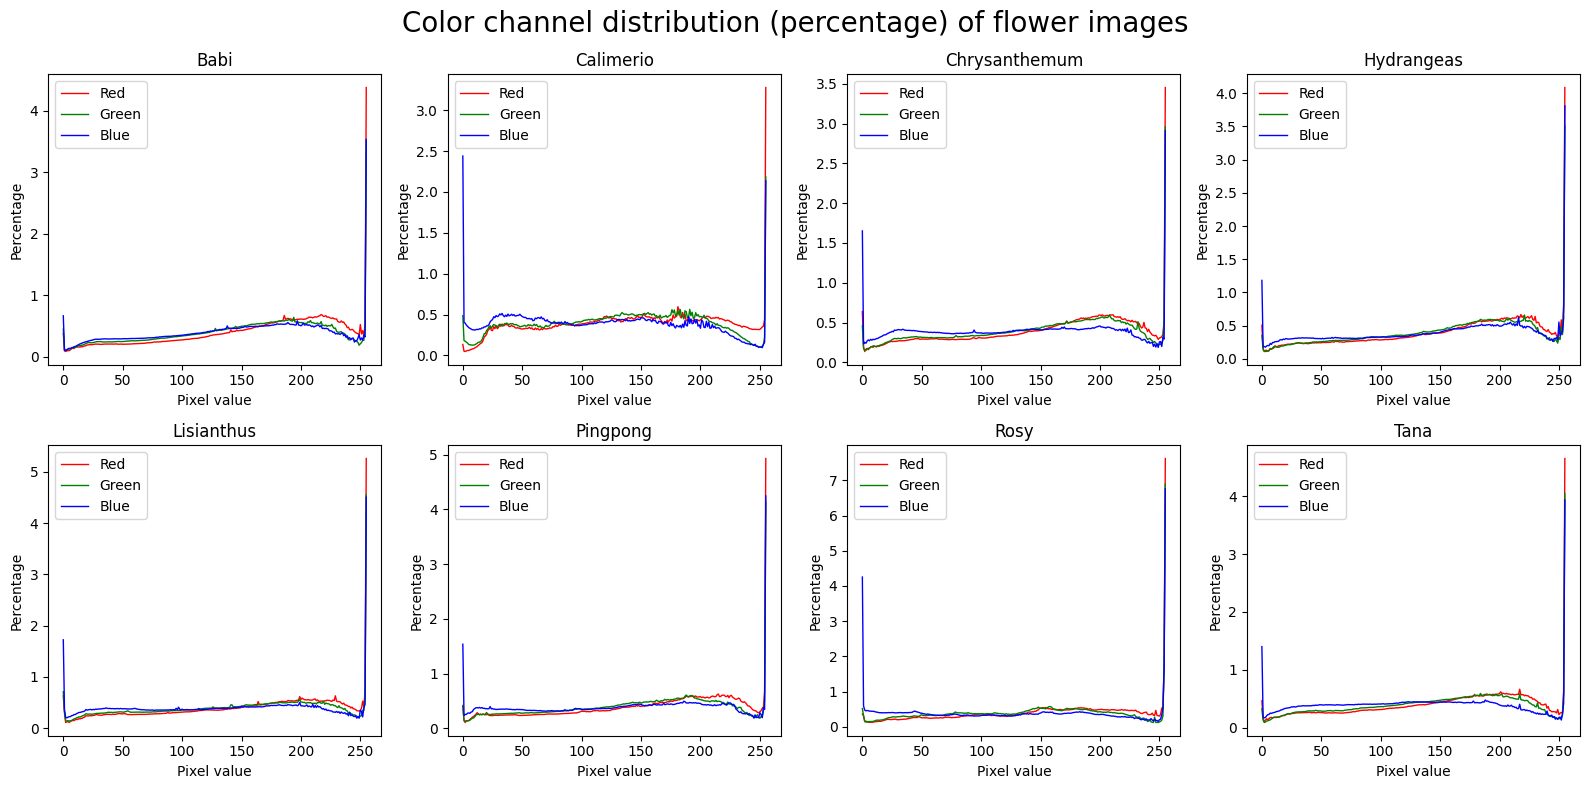

In [10]:
plot_color_distribution(flower_dataset_directory)

## 2.2. Image size distribution

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_size_distribution(img_dir):
    categories = os.listdir(img_dir)
    fig, axs = plt.subplots(2, 4, figsize=(20,10))
    fig.suptitle('Image Size Distribution by Category')
    for i, category in enumerate(categories):
        size_list = []
        for filename in os.listdir(os.path.join(img_dir, category)):
            img_path = os.path.join(img_dir, category, filename)
            img = cv2.imread(img_path)
            size = os.path.getsize(img_path)
            size_list.append(size)

        ax = axs[i//4, i%4]
        ax.hist(size_list, bins=50)
        ax.set_title(category)
        ax.set_xlabel('Image Size (Bytes)')
        ax.set_ylabel('Frequency')
    plt.show()


In [ ]:
plot_size_distribution(flower_dataset_directory)

## 2.3. Flower category distribution

In [ ]:
def plot_category_distribution(main_dir):
    categories = os.listdir(main_dir)
    category_counts = [len(os.listdir(os.path.join(main_dir, cat))) for cat in categories]
    plt.bar(categories, category_counts)
    plt.xticks(rotation=45)
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Flower Category Distribution')
    plt.show()

In [ ]:
plot_category_distribution(flower_dataset_directory)

# 3. Data cleaning

In [ ]:
IMAGE=[]
LABEL=[]
IMG_SIZE=200

def assign_label(img,flower_category):
    return flower_category

def make_train_data(flower_category,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_category)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        IMAGE.append(np.array(img))
        LABEL.append(str(label))

In [ ]:
FLOWER_DIR = []

for category in flower_category_foldername:
    flower_dir = f"data/Flowers/{category}"
    FLOWER_DIR.append(flower_dir)
    make_train_data(category, flower_dir)
print(len(IMAGE))

### Sample image

In [ ]:
sample_path="data/Flowers/Babi/babi_1.jpg"
destination_folder = r"Flowers_Cleaned/Flowers"

#read image
img = mpimg.imread(sample_path)

#show image
plt.imshow(img)

## 3.1. Noise Removal

In [ ]:
def remove_noise(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)

In [ ]:
def show_before_after(img,img_after,title_after):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original")

    plt.subplot(1,3,2)
    plt.imshow(img_after)
    plt.title(title_after)

In [ ]:
show_before_after(img,remove_noise(img),"After Noise Removal")

## 3.2. Normalization

This process changes the range of pixel intensity values. The purpose of performing normalization is to bring image to range that is normal to sense.

In [ ]:
def normalization(img):
    norm_img = np.zeros((img.shape[0], img.shape[1]))
    return cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)

In [ ]:
show_before_after(img,normalization(img),"After Normalization")

## 3.1. Check image filetype

In [ ]:
def check_image_extensions(input_dir, allowed_extensions):
    # Initialize a dictionary to count the number of files of each type
    file_count = {extension: 0 for extension in allowed_extensions}
    # Loop over each flower category
    for category in os.listdir(input_dir):
        # Get the path to the category directory
        category_dir = os.path.join(input_dir, category)
        # Loop over each image file in the category directory
        for filename in os.listdir(category_dir):
            # Get the file extension of the image file
            extension = os.path.splitext(filename)[-1]
            # Check if the extension is allowed
            if extension in allowed_extensions:
                # Increment the file count for the extension
                file_count[extension] += 1
            else:
                print(f"Error: {filename} in {category} has invalid extension {extension}")
    # Calculate the total number of files
    total_files = sum(file_count.values())
    # Print the percentage of each file type
    for extension, count in file_count.items():
        percentage = count / total_files * 100
        print(f"{extension}: {percentage:.2f}%")

In [ ]:
allowed_extensions = {".jpg"}
check_image_extensions(flower_dataset_directory, allowed_extensions)

## 3.2. Detect corrupt image

It is crucial to detect corrupted images, as they can negatively impact the performance of a machine learning model or computer vision system. Images that have been corrupted may contain noise, artifacts, or other anomalies that can lead to misclassifications or output errors. Improve the accuracy and dependability of a model or system by detecting and removing these images from the dataset. In addition, corrupted images can cause biases in the model or system, which can lead to erroneous results or unjust decisions.

In [ ]:
def clone_folder():
    shutil.copytree(flower_dataset_directory, destination_folder)
    print('Copied')

In [ ]:
clone_folder()

In [ ]:
corrupted_image = list()
accu = 0

for root, dirs, files in os.walk(flower_dataset_directory):
    for name in dirs:
        print(os.path.join(root, name))
        for image_file in Path(os.path.join(root, name)).glob('*.jpg'):
          accu = accu + 1
          try :
              image = imageio.imread(image_file)
            #   print(f'read {image_file}')
          except :
              print(f'Cannot read image {image_file}')
              corrupted_image.add(image_file)
print("Total number of images : ", accu)

In [ ]:
len(corrupted_image)

## 3.3. Image duplication detection

Duplicate image detection is essential for multiple reasons:

1. Reducing storage: Storing duplicate images wastes storage space, and detecting and removing them can help reduce storage costs.

2. Improving efficiency: Processing or analyzing duplicate images is inefficient and time-consuming. Removing duplicates can improve processing and analysis efficiency.

3. Enhancing accuracy: Duplicate images can bias the results of image-based analysis, such as object detection or image classification. Removing duplicates can improve the accuracy of these analyses.

4. Maintaining data integrity: Duplicates can lead to confusion and inconsistency in data, especially when dealing with large image datasets. Removing duplicates helps to maintain data integrity and consistency.

In [ ]:
def show_dupes(img_name1, img_name2):
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(Image.open(img_name1))
    title_name1=os.path.basename(img_name1).split('/')[-1]
    ax.set_title(title_name1)
    
    ax = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(Image.open(img_name2))
    title_name2=os.path.basename(img_name2).split('/')[-1]
    ax.set_title(title_name2)

In [ ]:
hashes = {}
duplicated = []   

# Define a function to compute the hash of an image file
def compute_hash(filepath):
    with Image.open(filepath) as img:
        return str(imagehash.phash(img))
    
# Define a function to find and remove duplicated images
def check_duplicates(rootdir):
    duplicated = []
    rootdir = glob.glob(rootdir)
    for folder in rootdir:
        print()
        print(folder)
        for image_dir in glob.glob(folder+'/*.jpg'):
            # Compute the hash of the image file
            file_hash = compute_hash(image_dir)
            # Check if this hash has already been seen
            file=os.path.basename(image_dir).split('/')[-1]
            if file_hash in hashes:
                # if the image hash exists already, save the collision filenames
                dupe_idx = hashes[file_hash]
                duplicated.append((dupe_idx, image_dir))
            else:
                # This file is not a duplicate, so remember its hash
                hashes[file_hash] = image_dir
        print(r'Duplicated image in ',folder,' :',len(duplicated))
    if len(duplicated)>0:
        print(r'---- Examples of duplication ----')
        show_dupes(duplicated[0][0], duplicated[0][1])
        show_dupes(duplicated[1][0], duplicated[1][1])
        show_dupes(duplicated[2][0], duplicated[2][1])

# Define a function to find and remove duplicated images
def remove_duplicates(rootdir):
    rootdir = glob.glob(rootdir)
    for folder in rootdir:
        print()
        print(folder)
        for image_dir in glob.glob(folder+'/*.jpg'):
            # Compute the hash of the image file
            file_hash = compute_hash(image_dir)
            # Check if this hash has already been seen
            file=os.path.basename(image_dir).split('/')[-1]
            if file_hash in hashes:
                os.remove(image_dir)
                print(f'Removed duplicate file: {file}')

In [ ]:
check_duplicates('Flowers_Cleaned/Flowers/*')

In [ ]:
remove_duplicates('Flowers_Cleaned/Flowers/*')

## 3.4. Check image resolution

In [ ]:
for img in IMAGE:
    print(img.shape)

## Check image outlier

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

def calculate_image_features(img_path):
    # Load the image and convert to grayscale
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the image's contrast and brightness
    min_gray = gray.min()
    max_gray = gray.max()
    contrast = (max_gray - min_gray) / max_gray
    brightness = gray.mean()
    
    # Return the image's features as a NumPy array
    return np.array([contrast, brightness])

def detect_outliers_in_category(category_path):
    # Calculate the features for each image in the category
    X = []
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        if os.path.isfile(file_path):
            features = calculate_image_features(file_path)
            X.append(features)
    X = np.array(X)
    
    # Detect outliers using the LOF algorithm
    clf = LocalOutlierFactor(n_neighbors=20)
    y_pred = clf.fit_predict(X)
    
    # Plot the LOF scores for each image
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='cool')
    plt.colorbar()
    plt.title(category_path)
    plt.xlabel('Contrast')
    plt.ylabel('Brightness')
    plt.show()

def detect_outliers_in_all_categories(root_path):
    for category_name in os.listdir(root_path):
        category_path = os.path.join(root_path, category_name)
        if os.path.isdir(category_path):
            detect_outliers_in_category(category_path)

In [ ]:
detect_outliers_in_all_categories(flower_dataset_directory)

# Task 1: Classification

# Task 2: Recommender

## VGG-16 - A Deep Convolutional Neural Network Architecture for Image Recognition

The VGG16 architecture, introduced by Karen Simonyan and Andrew Zisserman in 2014, has demonstrated remarkable performance in the field of image recognition. With its increased depth and improved representational power, VGG16 has become a popular choice for complex visual recognition tasks. This report provides an overview of the VGG16 model, highlighting its key characteristics, advantages, and disadvantages.

### Feature engineering

Resnet50 For Feature Extraction

In [ ]:
# display a single image
def display_image(path):
    img = Image.open(path)
    display(img)

Recommender using ResNet50 Features

Recommender using VGG16 Features

# Reference